# Final Data

## 0. Data load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/기상청/데이터')

In [ ]:
!pip install tslearn

     |████████████████████████████████| 798kB 24.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm.notebook import tqdm
tqdm.pandas()

import random
from functools import reduce

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='MalgunGothic')
plt.rcParams['axes.unicode_minus'] = False

from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [ ]:
product = pd.read_csv('ProductFiltering.csv', encoding='CP949')
buy_full = pd.read_csv('final_0613.csv', encoding='CP949')

In [ ]:
product.head(2)

,big_cat,sm_cat,평균기온,일별강수량,평균풍속,PM10,1시간최대습도,일조시간합,score
0,식품,감귤/한라봉/오렌지,0.781819,0.220087,0.143872,0.339007,0.264361,0.117065,1.866211
1,냉난방가전,복합식 가습기,0.799613,0.247738,0.070702,0.335301,0.319788,0.060826,1.833968


In [ ]:
buy_full.head(2)

,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50
0,2018-01-01,1,식품,가공란,37.0,0.0,10.69387,4.09137,0.0,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,2018-01-01,1,식품,가공란,16.0,0.0,12.42969,6.35294,0.0,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


## 1. Data Preprocessing

In [ ]:
buy_full = buy_full[buy_full.sm_cat.isin(list(product.sm_cat.unique()))]
print(buy_full.shape)
buy_full.head(2)

(1303336, 52)


,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50
16,2018-01-01,1,냉난방가전,가열식 가습기,1.0,24.75961,10.69387,4.09137,0.0,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
17,2018-01-01,1,냉난방가전,가열식 가습기,0.0,17.93893,12.42969,6.35294,0.0,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
buy_app = buy_full[buy_full['big_cat']=='냉난방가전'].reset_index(drop=True)
print(buy_app.shape)
buy_app.head(2)

(189096, 52)


,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50
0,2018-01-01,1,냉난방가전,가열식 가습기,1.0,24.75961,10.69387,4.09137,0.0,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,2018-01-01,1,냉난방가전,가열식 가습기,0.0,17.93893,12.42969,6.35294,0.0,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
buy_app['date'] = pd.to_datetime(buy_app['date'], format='%Y-%m-%d')
buy_app['year'] = buy_app['date'].dt.year
buy_2018 = buy_app[buy_app.year==2018]
buy_2019 = buy_app[buy_app.year==2019]
buy_2018.shape, buy_2019.shape

((93879, 53), (95217, 53))

In [ ]:
buy_2018["date"] = buy_2018["date"] + datetime.timedelta(days=-1)
buy_2018["date"] = buy_2018["date"].progress_apply(lambda x : x.replace(year=2018, month=12, day=31) if x==datetime.date(2017, 12, 31) else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
buy_2018_cat = buy_2018.groupby(['date', 'sm_cat']).sum('qty').reset_index()[['date', 'sm_cat', 'qty']]
buy_2019_cat = buy_2019.groupby(['date', 'sm_cat']).sum('qty').reset_index()[['date', 'sm_cat', 'qty']]
buy_2018_cat["date"] = buy_2018_cat["date"].progress_apply(lambda x : str(x)[5:10])
buy_2019_cat["date"] = buy_2019_cat["date"].progress_apply(lambda x : str(x)[5:10])
buy_2018_ts = pd.pivot_table(buy_2018_cat, index="sm_cat", columns="date", values="qty")
buy_2019_ts = pd.pivot_table(buy_2019_cat, index="sm_cat", columns="date", values="qty")
buy_2018_ts.shape, buy_2019_ts.shape

((31, 365), (31, 365))

In [ ]:
buy_2018_ts = buy_2018_ts.fillna(0)
buy_2019_ts = buy_2019_ts.fillna(0)

In [ ]:
avg_lst = []; std_lst = []
for idx, row in tqdm(buy_2018_ts.iterrows()):
    avg_lst.append(row.mean())
    std_lst.append(row.std())

buy_2018_ts['avg'] = avg_lst
buy_2018_ts['std'] = std_lst

for i in tqdm(range(len(buy_2018_ts))):
    for j in range(365):
        buy_2018_ts.iloc[i,j] = (buy_2018_ts.iloc[i,j] - buy_2018_ts.iloc[i,365])/buy_2018_ts.iloc[i,366]

buy_2018_ts = buy_2018_ts.drop(['avg','std'], axis=1)

In [ ]:
avg_lst = []; std_lst = []
for idx, row in tqdm(buy_2019_ts.iterrows()):
    avg_lst.append(row.mean())
    std_lst.append(row.std())

buy_2019_ts['avg'] = avg_lst
buy_2019_ts['std'] = std_lst

for i in tqdm(range(len(buy_2019_ts))):
    for j in range(365):
        buy_2019_ts.iloc[i,j] = (buy_2019_ts.iloc[i,j] - buy_2019_ts.iloc[i,365])/buy_2019_ts.iloc[i,366]

buy_2019_ts = buy_2019_ts.drop(['avg','std'], axis=1)

In [ ]:
buy_ts = (buy_2018_ts + buy_2019_ts)/2

In [ ]:
print(buy_ts.shape)
buy_ts.head(2)

(31, 365)


date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-22,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가열식 가습기,2.034589,1.327837,1.533372,1.410790,0.556221,1.201658,1.111509,1.320641,1.601883,0.970888,0.48771,0.372324,0.192026,0.329049,0.559819,0.119917,0.123515,0.119917,-0.251475,-0.017106,0.047807,0.325451,0.556221,0.549025,0.574261,-0.319986,0.206468,0.988927,0.689646,0.393962,0.073043,-0.114452,-0.345222,-0.139688,-0.143286,-0.301946,-0.182963,0.141554,0.300215,-0.276710,...,1.663198,0.711283,1.151186,1.879527,1.659600,2.286997,1.454066,1.136745,0.729274,0.538181,2.085061,2.651143,2.135533,2.618711,4.115021,1.792976,2.175210,3.639137,3.372336,2.748537,2.467295,2.005755,1.169225,1.320641,2.589877,1.558656,1.273767,1.861487,1.479302,0.538181,1.259326,1.627119,1.158382,1.147588,1.136745,2.323076,0.924014,1.143990,1.180020,0.422796
공기정화 용품,-0.091721,-0.111593,-0.300766,-0.020664,-0.434600,-0.433411,0.079613,0.037852,-0.321782,-0.195039,0.04836,-0.538912,-0.137757,1.588938,1.600003,2.160103,1.359735,1.434796,0.573835,0.821691,0.944444,0.355440,0.100388,0.047593,0.161750,-0.120911,-0.244659,0.378218,-0.020980,0.193274,0.018839,-0.279826,-0.593364,0.077596,-0.193308,-0.311500,0.218836,0.274989,-0.020980,-0.320563,...,-0.303567,-0.511950,0.037822,-0.014763,0.396148,0.388485,1.166934,-0.157298,-0.502435,-0.369098,0.214983,-0.099895,-0.336581,-0.185946,-0.440200,-0.640951,-0.480847,0.078800,0.155713,0.278497,-0.260586,-0.330680,-0.541170,-0.480351,0.288222,-0.239751,-0.135981,0.324007,-0.313111,-0.434133,-0.059821,-0.004797,-0.051782,-0.026806,-0.183959,-0.248919,-0.524686,-0.518468,-0.078503,-0.157313


## 2. Time Sereis Clustering

In [ ]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in tqdm(range(2, 7)):
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)
    return distortions

In [ ]:
distortions = visualize_elbowmethod(buy_ts)

findfont: Font family ['MalgunGothic'] not found. Falling back to DejaVu Sans.


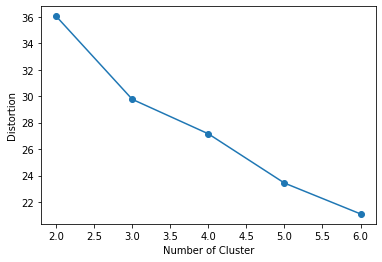

In [ ]:
plt.plot(range(2, 7), distortions, marker='o')
plt.xlabel('Number of Cluster')
plt.ylabel('Distortion')
plt.show()

In [ ]:
%%time
model_dtw = TimeSeriesKMeans(n_clusters=3, init='random', n_init=10, max_iter=300, random_state=1234, metric = 'dtw').fit(buy_ts)

CPU times: user 1min 16s, sys: 48 s, total: 2min 4s
Wall time: 1min 12s


In [ ]:
result_dtw = model_dtw.predict(buy_ts)
buy_ts['cluster'] = result_dtw
buy_ts.head(2)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 31 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


date,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,02-09,...,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,cluster
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가열식 가습기,2.034589,1.327837,1.533372,1.410790,0.556221,1.201658,1.111509,1.320641,1.601883,0.970888,0.48771,0.372324,0.192026,0.329049,0.559819,0.119917,0.123515,0.119917,-0.251475,-0.017106,0.047807,0.325451,0.556221,0.549025,0.574261,-0.319986,0.206468,0.988927,0.689646,0.393962,0.073043,-0.114452,-0.345222,-0.139688,-0.143286,-0.301946,-0.182963,0.141554,0.300215,-0.276710,...,0.711283,1.151186,1.879527,1.659600,2.286997,1.454066,1.136745,0.729274,0.538181,2.085061,2.651143,2.135533,2.618711,4.115021,1.792976,2.175210,3.639137,3.372336,2.748537,2.467295,2.005755,1.169225,1.320641,2.589877,1.558656,1.273767,1.861487,1.479302,0.538181,1.259326,1.627119,1.158382,1.147588,1.136745,2.323076,0.924014,1.143990,1.180020,0.422796,0
공기정화 용품,-0.091721,-0.111593,-0.300766,-0.020664,-0.434600,-0.433411,0.079613,0.037852,-0.321782,-0.195039,0.04836,-0.538912,-0.137757,1.588938,1.600003,2.160103,1.359735,1.434796,0.573835,0.821691,0.944444,0.355440,0.100388,0.047593,0.161750,-0.120911,-0.244659,0.378218,-0.020980,0.193274,0.018839,-0.279826,-0.593364,0.077596,-0.193308,-0.311500,0.218836,0.274989,-0.020980,-0.320563,...,-0.511950,0.037822,-0.014763,0.396148,0.388485,1.166934,-0.157298,-0.502435,-0.369098,0.214983,-0.099895,-0.336581,-0.185946,-0.440200,-0.640951,-0.480847,0.078800,0.155713,0.278497,-0.260586,-0.330680,-0.541170,-0.480351,0.288222,-0.239751,-0.135981,0.324007,-0.313111,-0.434133,-0.059821,-0.004797,-0.051782,-0.026806,-0.183959,-0.248919,-0.524686,-0.518468,-0.078503,-0.157313,1


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


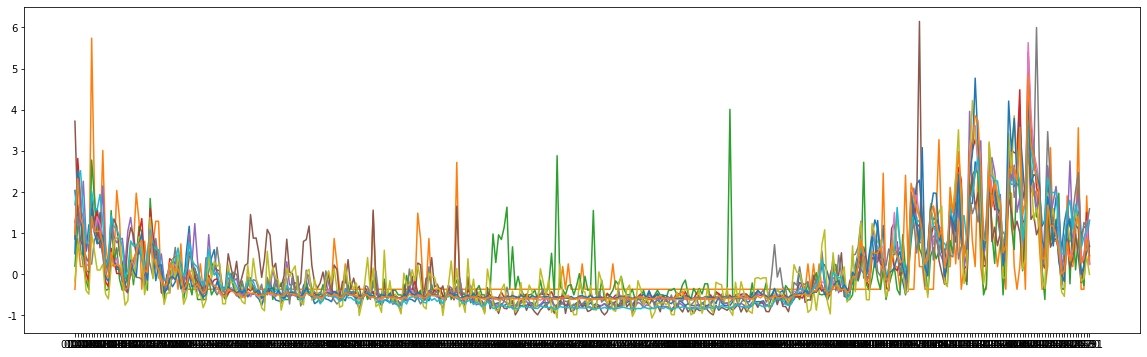

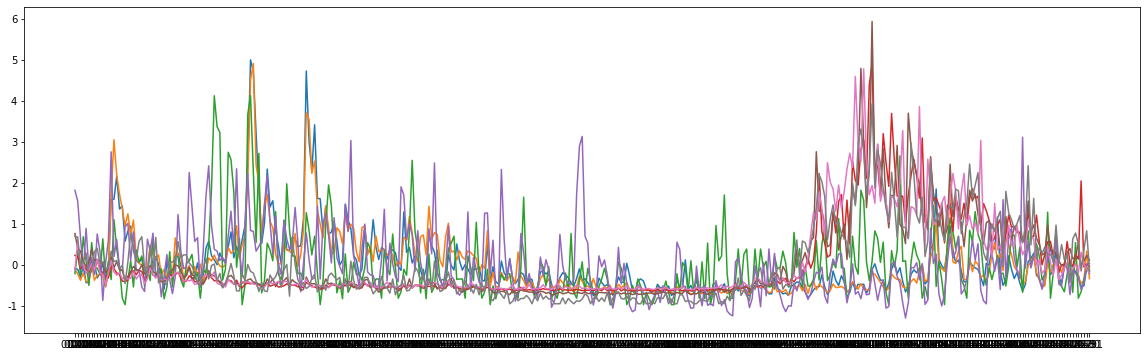

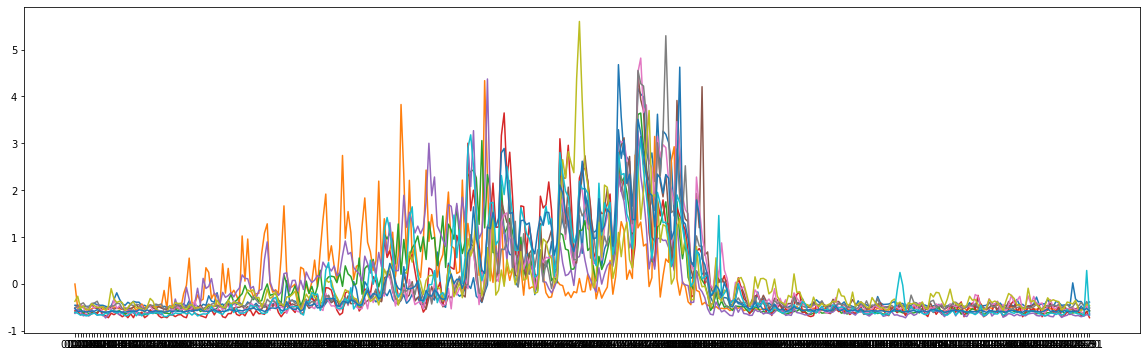

In [ ]:
for i in range(3):
    clusters = buy_ts[buy_ts['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

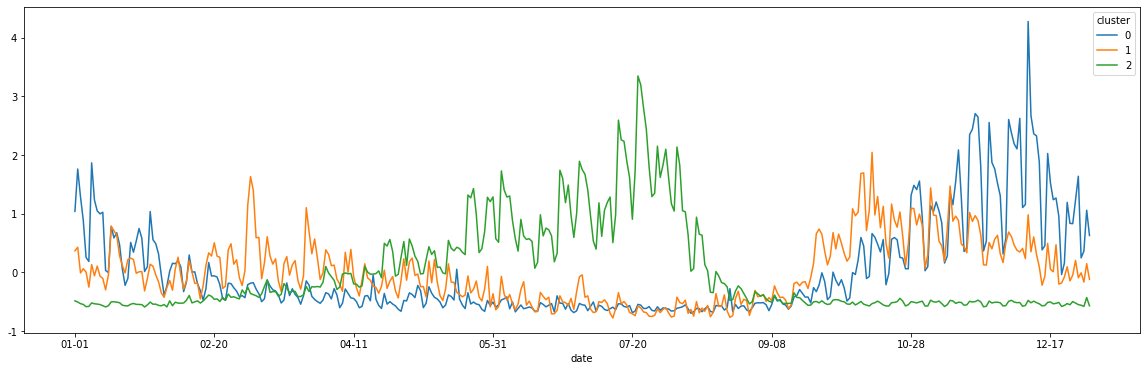

In [ ]:
plt.rcParams["figure.figsize"]=(20,6)
buy_ts.groupby(['cluster']).mean().T.plot()
plt.show()

In [ ]:
data_final = buy_ts.reset_index()
data_final.head(2)

date,sm_cat,01-01,01-02,01-03,01-04,01-05,01-06,01-07,01-08,01-09,01-10,01-11,01-12,01-13,01-14,01-15,01-16,01-17,01-18,01-19,01-20,01-21,01-22,01-23,01-24,01-25,01-26,01-27,01-28,01-29,01-30,01-31,02-01,02-02,02-03,02-04,02-05,02-06,02-07,02-08,...,11-23,11-24,11-25,11-26,11-27,11-28,11-29,11-30,12-01,12-02,12-03,12-04,12-05,12-06,12-07,12-08,12-09,12-10,12-11,12-12,12-13,12-14,12-15,12-16,12-17,12-18,12-19,12-20,12-21,12-22,12-23,12-24,12-25,12-26,12-27,12-28,12-29,12-30,12-31,cluster
0,가열식 가습기,2.034589,1.327837,1.533372,1.410790,0.556221,1.201658,1.111509,1.320641,1.601883,0.970888,0.48771,0.372324,0.192026,0.329049,0.559819,0.119917,0.123515,0.119917,-0.251475,-0.017106,0.047807,0.325451,0.556221,0.549025,0.574261,-0.319986,0.206468,0.988927,0.689646,0.393962,0.073043,-0.114452,-0.345222,-0.139688,-0.143286,-0.301946,-0.182963,0.141554,0.300215,...,0.711283,1.151186,1.879527,1.659600,2.286997,1.454066,1.136745,0.729274,0.538181,2.085061,2.651143,2.135533,2.618711,4.115021,1.792976,2.175210,3.639137,3.372336,2.748537,2.467295,2.005755,1.169225,1.320641,2.589877,1.558656,1.273767,1.861487,1.479302,0.538181,1.259326,1.627119,1.158382,1.147588,1.136745,2.323076,0.924014,1.143990,1.180020,0.422796,0
1,공기정화 용품,-0.091721,-0.111593,-0.300766,-0.020664,-0.434600,-0.433411,0.079613,0.037852,-0.321782,-0.195039,0.04836,-0.538912,-0.137757,1.588938,1.600003,2.160103,1.359735,1.434796,0.573835,0.821691,0.944444,0.355440,0.100388,0.047593,0.161750,-0.120911,-0.244659,0.378218,-0.020980,0.193274,0.018839,-0.279826,-0.593364,0.077596,-0.193308,-0.311500,0.218836,0.274989,-0.020980,...,-0.511950,0.037822,-0.014763,0.396148,0.388485,1.166934,-0.157298,-0.502435,-0.369098,0.214983,-0.099895,-0.336581,-0.185946,-0.440200,-0.640951,-0.480847,0.078800,0.155713,0.278497,-0.260586,-0.330680,-0.541170,-0.480351,0.288222,-0.239751,-0.135981,0.324007,-0.313111,-0.434133,-0.059821,-0.004797,-0.051782,-0.026806,-0.183959,-0.248919,-0.524686,-0.518468,-0.078503,-0.157313,1


In [ ]:
pd.set_option('display.max_rows', 2000)
for i in range(3):
    print("클러스터",i)
    print("소분류 개수: ",data_final[data_final['cluster']==i]['sm_cat'].shape[0])
    print(data_final[data_final['cluster']==i]['sm_cat'])
    print('======='*10)

클러스터 0
소분류 개수:  12
0      가열식 가습기
3      난방용 열풍기
5          돈풍기
6        라디에이터
11     복합식 가습기
14        에어워셔
17         온풍기
20     자연식 가습기
21       전기온수기
24    초음파식 가습기
26         컨벡터
30          히터
Name: sm_cat, dtype: object
클러스터 1
소분류 개수:  8
1     공기정화 용품
2       공기청정기
10        보일러
16       온수매트
18      의류건조기
22       전기장판
25      카페트매트
28       황토매트
Name: sm_cat, dtype: object
클러스터 2
소분류 개수:  11
4            냉풍기
7        멀티형 에어컨
8        벽걸이 에어컨
9       벽걸이형 선풍기
12      스탠드형 에어컨
13       업소용 선풍기
15       에어컨 리모컨
19       이동형 에어컨
23           제습기
27    탁상/USB 선풍기
29       휴대용 선풍기
Name: sm_cat, dtype: object


In [ ]:
data_final.to_csv('/content/drive/MyDrive/기상청/데이터/app_clustering_0613.csv', encoding='CP949', index = False)\

## 3. Modeling

In [ ]:
appliance = pd.read_csv('app_clustering_0613.csv', encoding='cp949')
product = pd.read_csv("final_weather_0613.csv", encoding="cp949")
weather = pd.read_csv("weather_final2.csv", encoding="cp949")

appliance.shape, product.shape, weather.shape

((31, 367), (1303336, 52), (11680, 29))

In [ ]:
product['date'] = pd.to_datetime(product['date'], format='%Y-%m-%d')
weather['날짜'] = pd.to_datetime(weather['날짜'], format='%Y-%m-%d')
weather = weather.rename(columns={"날짜" : "date"})

In [ ]:
def region_weather(loc):
    weather_true = weather.drop(['연', '월', '일', '분기', '요일', '공휴일명', '공휴일여부', '주말여부', '계절', 'year', 'month'], axis=1) 
    weather1 = pd.pivot_table(weather_true[weather_true['지역'] == loc], index='date', columns='지역').reset_index(level=0)
    weather1.columns = [l+"_"+w for l,w in zip(weather1.columns.get_level_values(1), weather1.columns.get_level_values(0))]
    return weather1.rename(columns = {'_date' : 'date'})

In [ ]:
def cluster_df(big_cat, product_cat) : 
    
    '''
    big_cat : TimeSeries Clustering 결과 파일 (pivot table 형태의 dataframe)
    product_cat : big_category 에 해당되는 dataframe 
    '''
    
    cluster0 = big_cat[big_cat["cluster"] == 0] 
    cluster1 = big_cat[big_cat["cluster"] == 1]
    cluster2 = big_cat[big_cat["cluster"] == 2]
    
    cluster0 = list(cluster0['sm_cat']) 
    cluster1 = list(cluster1['sm_cat']) 
    cluster2 = list(cluster2['sm_cat']) 
    
    big_c0 = product_cat[product_cat['sm_cat'].isin(cluster0)].reset_index(drop=True)
    big_c1 = product_cat[product_cat['sm_cat'].isin(cluster1)].reset_index(drop=True)
    big_c2 = product_cat[product_cat['sm_cat'].isin(cluster2)].reset_index(drop=True)
    
    return big_c0, big_c1, big_c2

In [ ]:
bty_c0, bty_c1, bty_c2 = cluster_df(appliance, product)
bty_c0.shape, bty_c1.shape, bty_c2.shape

((67769, 52), (56127, 52), (65200, 52))

In [ ]:
bty_c0.head(2)

,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50
0,2018-01-01,1,냉난방가전,가열식 가습기,1.0,24.75961,10.69387,4.09137,0.0,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,2018-01-01,1,냉난방가전,가열식 가습기,0.0,17.93893,12.42969,6.35294,0.0,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
# sm_cat one hot encoding 
bty_c0 = pd.get_dummies(bty_c0, columns=['sm_cat'], drop_first = True)
bty_c1 = pd.get_dummies(bty_c1, columns=['sm_cat'], drop_first = True)
bty_c2 = pd.get_dummies(bty_c2, columns=['sm_cat'], drop_first = True)

bty_c0.shape, bty_c1.shape, bty_c2.shape 

((67769, 62), (56127, 58), (65200, 61))

In [ ]:
def loc_df(cluster) : 
    
    '''
    - 수도권: 서울
    - 강원: 강릉
    - 경북: 대구
    - 경남: 부산
    - 전남: 광주
    - 전북: 전주 
    - 충남: 대전
    - 충북: 청주 
    - 제주: 제주
    '''
    
    c0_1 = cluster.merge(region_weather('서울'), on="date", how='left')
    c0_2 = cluster.merge(region_weather('강릉'), on="date", how='left')
    c0_3 = cluster.merge(region_weather('대구'), on="date", how='left')
    c0_4 = cluster.merge(region_weather('부산'), on="date", how='left')
    c0_5 = cluster.merge(region_weather('광주'), on="date", how='left')
    c0_6 = cluster.merge(region_weather('전주'), on="date", how='left')
    c0_7 = cluster.merge(region_weather('대전'), on="date", how='left')
    c0_8 = cluster.merge(region_weather('청주'), on="date", how='left')
    c0_9 = cluster.merge(region_weather('제주'), on="date", how='left')  
    
    return c0_1, c0_2, c0_3, c0_4, c0_5, c0_6, c0_7, c0_8, c0_9

In [ ]:
bty_c0_1, bty_c0_2, bty_c0_3, bty_c0_4, bty_c0_5, bty_c0_6, bty_c0_7, bty_c0_8, bty_c0_9 = loc_df(bty_c0) 
bty_c0_1.shape, bty_c0_2.shape, bty_c0_3.shape, bty_c0_4.shape, bty_c0_5.shape, bty_c0_6.shape, bty_c0_7.shape, bty_c0_8.shape, bty_c0_9.shape

((67769, 78),
 (67769, 78),
 (67769, 78),
 (67769, 78),
 (67769, 78),
 (67769, 78),
 (67769, 78),
 (67769, 78),
 (67769, 78))

In [ ]:
bty_c0_1.head(2)

,date,sex,big_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50,sm_cat_난방용 열풍기,sm_cat_돈풍기,sm_cat_라디에이터,sm_cat_복합식 가습기,sm_cat_에어워셔,sm_cat_온풍기,sm_cat_자연식 가습기,sm_cat_전기온수기,sm_cat_초음파식 가습기,sm_cat_컨벡터,sm_cat_히터,서울_1시간최대강수량,서울_1시간최대습도,서울_PM10,서울_PM25,서울_강수여부,서울_열지수,서울_일별강수량,서울_일조시간합,서울_지점번호,서울_체감온도,서울_최고기온,서울_최고현지기압,서울_최저기온,서울_평균기온,서울_평균풍속,서울_폭염여부
0,2018-01-01,1,냉난방가전,1.0,24.75961,10.69387,4.09137,0.0,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,57.1,42.307692,21.470696,0,-44.993999,0.0,51.6,108,9.649709,3.8,1018.1,-5.1,-1.3,1.4,0
1,2018-01-01,1,냉난방가전,0.0,17.93893,12.42969,6.35294,0.0,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,57.1,42.307692,21.470696,0,-44.993999,0.0,51.6,108,9.649709,3.8,1018.1,-5.1,-1.3,1.4,0


In [ ]:
def sampling(data):
    # 랜덤으로 요일 선택
    np.random.seed(1234)
    sample_day = []; sample_idx = []
    count = 730//7 
    day_list = day_list = [1,2,3,4,5,6,7]
    sample_list = [random.choice(day_list) for i in range(count)]

    # 랜덤으로 선택된 요일의 날짜
    start = datetime.datetime(2018, 1, 1)
    for days in sample_list:
        sample_day.append(start + datetime.timedelta(days = days))
        start = start + datetime.timedelta(weeks = 1)

    # 샘플링
    for date in sample_day:
        sample_idx.extend(data[data['date']==date].index)
        
    all_idx = data.index.tolist()
    train_idx = list(set(all_idx) - set(sample_idx))
    return data.iloc[train_idx].reset_index(drop=True), data.iloc[sample_idx].reset_index(drop=True)

In [ ]:
train_1, test_1 = sampling(bty_c0_1)
train_2, test_2 = sampling(bty_c0_2)
train_3, test_3 = sampling(bty_c0_3)
train_4, test_4 = sampling(bty_c0_4)
train_5, test_5 = sampling(bty_c0_5)
train_6, test_6 = sampling(bty_c0_6)
train_7, test_7 = sampling(bty_c0_7)
train_8, test_8 = sampling(bty_c0_8)
train_9, test_9 = sampling(bty_c0_9)

In [ ]:
print(train_1.shape, test_1.shape)
print(train_2.shape, test_2.shape)
print(train_3.shape, test_3.shape)
print(train_4.shape, test_4.shape)
print(train_5.shape, test_5.shape)
print(train_6.shape, test_6.shape)
print(train_7.shape, test_7.shape)
print(train_8.shape, test_8.shape)
print(train_9.shape, test_9.shape)

(58176, 78) (9593, 78)
(58059, 78) (9710, 78)
(58162, 78) (9607, 78)
(58093, 78) (9676, 78)
(58047, 78) (9722, 78)
(58130, 78) (9639, 78)
(58042, 78) (9727, 78)
(58058, 78) (9711, 78)
(58126, 78) (9643, 78)


In [ ]:
train_8.tail(2)

,date,sex,big_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50,sm_cat_난방용 열풍기,sm_cat_돈풍기,sm_cat_라디에이터,sm_cat_복합식 가습기,sm_cat_에어워셔,sm_cat_온풍기,sm_cat_자연식 가습기,sm_cat_전기온수기,sm_cat_초음파식 가습기,sm_cat_컨벡터,sm_cat_히터,청주_1시간최대강수량,청주_1시간최대습도,청주_PM10,청주_PM25,청주_강수여부,청주_열지수,청주_일별강수량,청주_일조시간합,청주_지점번호,청주_체감온도,청주_최고기온,청주_최고현지기압,청주_최저기온,청주_평균기온,청주_평균풍속,청주_폭염여부
58056,2019-12-31,0,냉난방가전,23.0,25.18518,49.94212,2.41013,0.0,4.81481,0.10649,-3.153771,0.872542,-5.469094,0.0,0.005885,3.414438,19.590719,10.860786,61.658,47.797865,927.43791,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,83.3,23.182927,14.207317,0,-54.183964,0.0,54.9,131,4.779672,-1.4,1029.4,-8.0,-5.7,2.2,0
58057,2019-12-31,0,냉난방가전,10.0,21.95121,67.48388,4.62476,0.0,19.13043,0.69605,-3.153771,0.872542,-5.469094,0.0,0.005885,3.414438,19.590719,10.860786,61.658,47.797865,927.43791,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,83.3,23.182927,14.207317,0,-54.183964,0.0,54.9,131,4.779672,-1.4,1029.4,-8.0,-5.7,2.2,0
